In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.constants import DatasetPath
from datasets.schema import DatasetSchema
from datasets.loading import load_igraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetPath('ucidata-zachary')
schema = DatasetSchema.load_schema(DATASET.name)
G = load_igraph(schema)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: False
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

No node timestamp data available


In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 34
Number of Edges: 156
Density: 0.27807486631016043


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 9.176470588235293
Median Degree: 6.0


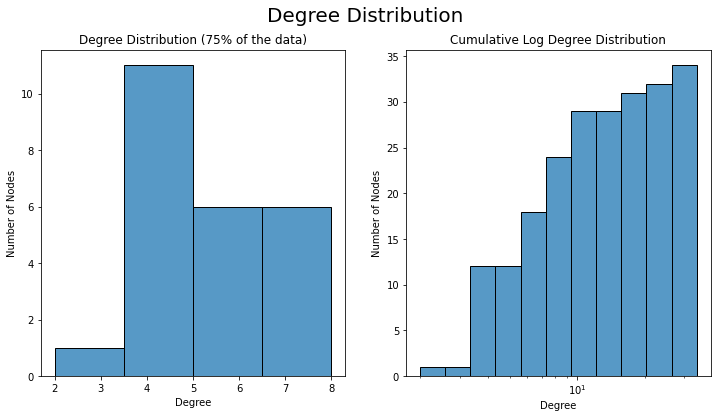

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,34,34
1,32,1
2,24,33
3,20,3
4,18,2
5,12,32
6,12,4
7,10,9
8,10,24
9,10,14


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.clusters().giant()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.531
Diameter: 5


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,34.000000,34.000000,34.000000,34.000000,33.000000
mean,0.278075,0.025568,0.146411,0.029412,0.587931
std,0.235019,0.055010,0.090649,0.022129,0.337614
min,0.060606,0.000000,0.023635,0.009565,0.000000
25%,0.121212,0.000000,0.080673,0.014580,0.333333
50%,0.181818,0.000000,0.102041,0.021979,0.500000
75%,0.303030,0.016098,0.186967,0.029708,1.000000
max,1.030303,0.264935,0.373371,0.100918,1.000000


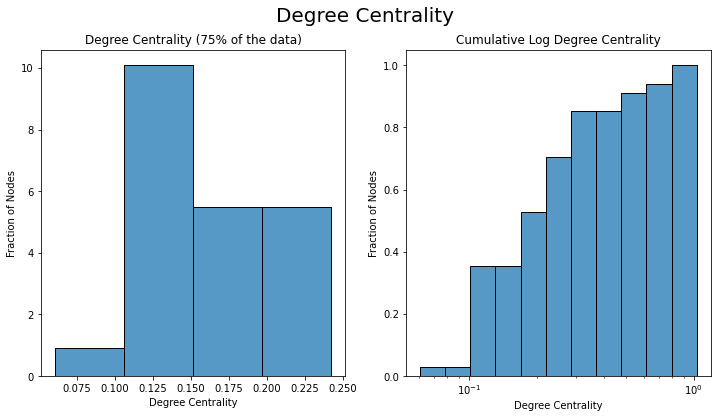

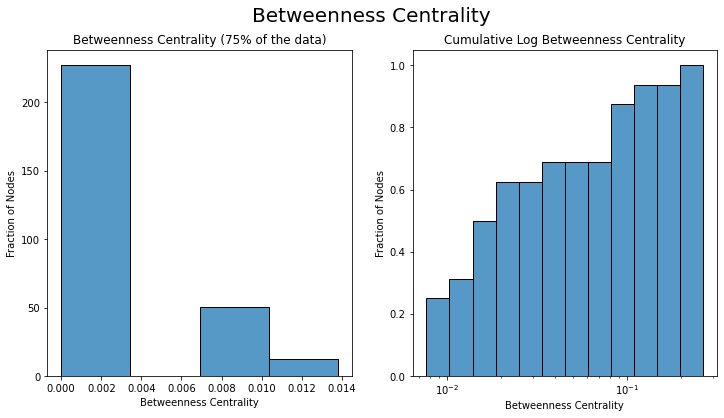

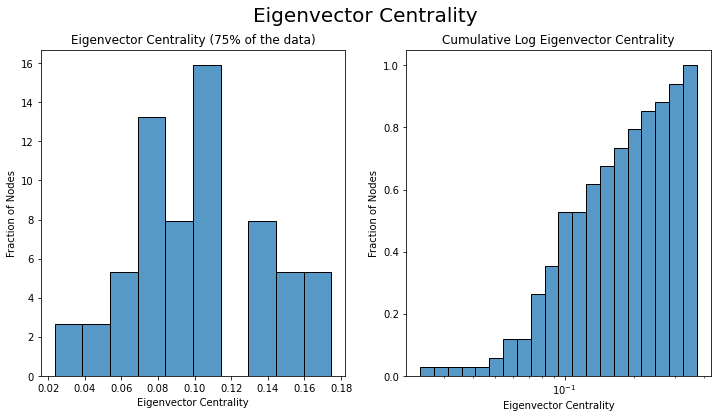

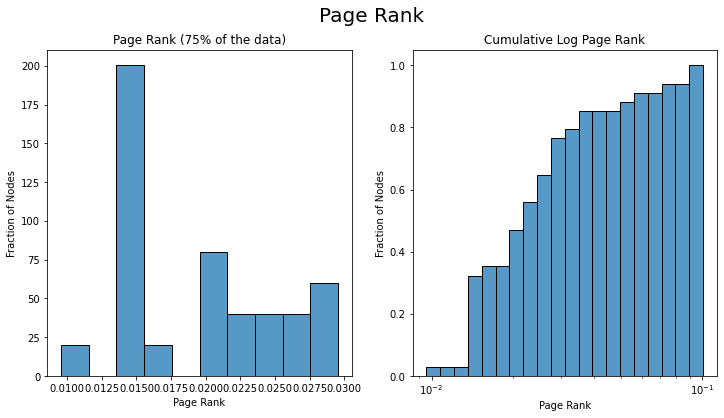

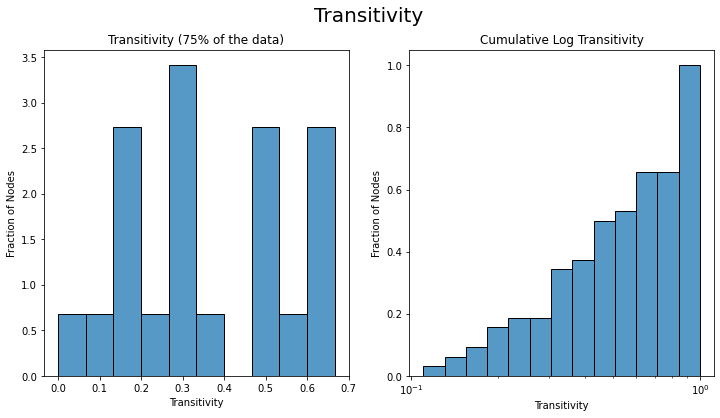

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,1.030303,34,0.264935,1,0.373371,34,0.100918,34,1.0,21
1,0.969697,1,0.145116,14,0.355483,1,0.097002,1,1.0,23
2,0.727273,33,0.106480,32,0.317189,3,0.071692,33,1.0,19
3,0.606061,3,0.096514,20,0.308651,33,0.057078,3,1.0,18
4,0.545455,2,0.081949,9,0.265954,2,0.052878,2,1.0,15
5,0.363636,4,0.034497,2,0.227405,9,0.037157,32,1.0,16
6,0.363636,32,0.023764,28,0.226470,14,0.035861,4,1.0,8
7,0.303030,14,0.022231,31,0.211174,4,0.031521,24,1.0,13
8,0.303030,9,0.016098,6,0.191036,32,0.029765,9,1.0,17
9,0.303030,24,0.016098,24,0.174760,31,0.029536,14,1.0,27


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components())}')
largest_cc = G.components().giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 1
Size of the largest component: 34


Text(0.5, 1.0, 'Connected Components')

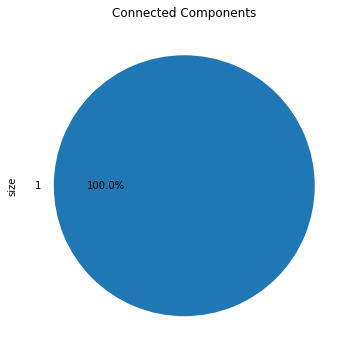

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components())], index=range(1,len(G.components())+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 1


,type,count,degree_avg,degree_median
Pupil,Pupil,34,9.176471,6.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

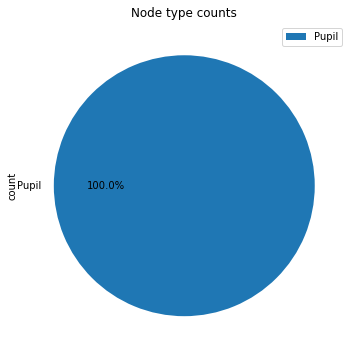

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

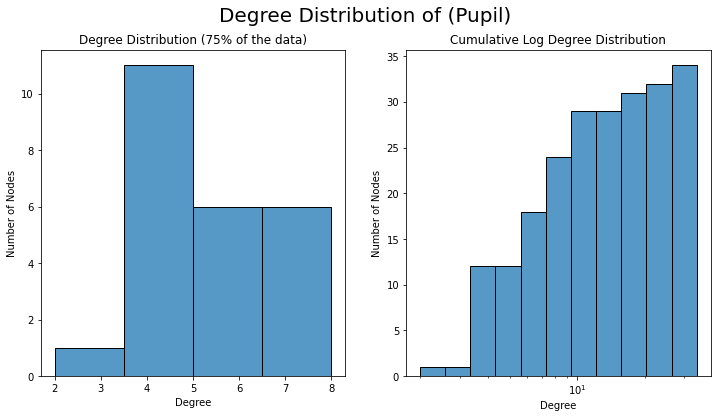

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Pupil)


,value,label
0,34,34
1,32,1
2,24,33
3,20,3
4,18,2
5,12,32
6,12,4
7,10,9
8,10,24
9,10,14


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 1


,type,count
TRAINS,TRAINS,156


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

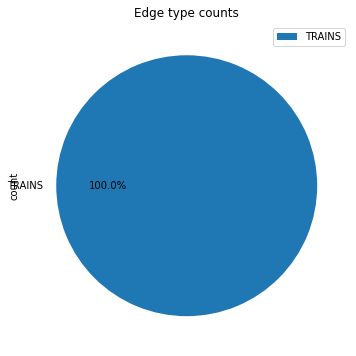

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Pupil


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,1.030303,34,0.264935,1,0.373371,34,0.100918,34,1.0,18
1,0.969697,1,0.145116,14,0.355483,1,0.097002,1,1.0,13
2,0.727273,33,0.106480,32,0.317189,3,0.071692,33,1.0,27
3,0.606061,3,0.096514,20,0.308651,33,0.057078,3,1.0,23
4,0.545455,2,0.081949,9,0.265954,2,0.052878,2,1.0,22
5,0.363636,4,0.034497,2,0.227405,9,0.037157,32,1.0,21
6,0.363636,32,0.023764,28,0.226470,14,0.035861,4,1.0,19
7,0.303030,24,0.022231,31,0.211174,4,0.031521,24,1.0,16
8,0.303030,9,0.016098,7,0.191036,32,0.029765,9,1.0,15
9,0.303030,14,0.016098,6,0.174760,31,0.029536,14,1.0,17


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.4197896120973044
Number of communities: 4


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

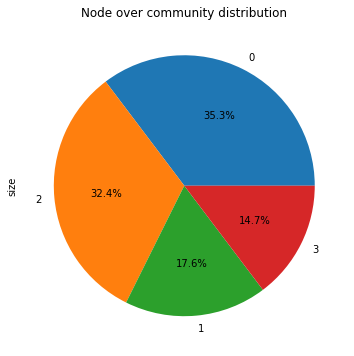

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,1.030303,34,0.081949,9,0.373371,34,0.100918,34,1.000000,27
1,0.727273,33,0.022231,31,0.308651,33,0.071692,33,1.000000,16
2,0.303030,9,0.007666,10,0.227405,9,0.029765,9,1.000000,19
3,0.242424,31,0.007666,33,0.174760,31,0.026287,30,1.000000,15
4,0.242424,30,0.000000,27,0.134965,30,0.024589,31,1.000000,23
5,0.121212,27,0.000000,16,0.102675,10,0.015043,27,1.000000,21
6,0.121212,16,0.000000,19,0.101406,16,0.014535,16,0.666667,30
7,0.121212,19,0.000000,15,0.101406,19,0.014535,19,0.500000,31
8,0.121212,15,0.000000,23,0.101406,15,0.014535,15,0.500000,9
9,0.121212,23,0.000000,21,0.101406,23,0.014535,23,0.196970,33


No node timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.363636,32,0.106480,32,0.191036,32,0.037157,32,0.400000,24
1,0.303030,24,0.023764,28,0.150123,24,0.031521,24,0.333333,26
2,0.242424,28,0.016098,24,0.133479,28,0.025639,28,0.333333,25
3,0.181818,26,0.007666,29,0.131079,29,0.021075,25,0.333333,29
4,0.181818,25,0.000000,26,0.059208,26,0.021006,26,0.200000,32
5,0.181818,29,0.000000,25,0.057054,25,0.019573,29,0.166667,28


No node timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.969697,1,0.264935,1,0.355483,1,0.097002,1,1.000000,22
1,0.606061,3,0.145116,14,0.317189,3,0.057078,3,1.000000,13
2,0.545455,2,0.096514,20,0.265954,2,0.052878,2,1.000000,8
3,0.363636,4,0.034497,2,0.226470,14,0.035861,4,1.000000,18
4,0.303030,14,0.013799,3,0.211174,4,0.029536,14,0.666667,4
5,0.242424,8,0.008739,4,0.170955,8,0.024491,8,0.600000,14
6,0.181818,20,0.000000,12,0.147911,20,0.019604,20,0.333333,20
7,0.121212,22,0.000000,22,0.092397,22,0.014645,13,0.333333,2
8,0.121212,13,0.000000,13,0.092397,18,0.014559,22,0.244444,3
9,0.121212,18,0.000000,8,0.084252,13,0.014559,18,0.150000,1


No node timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.242424,6,0.016098,6,0.079481,6,0.029113,6,1.000000,17
1,0.242424,7,0.016098,7,0.079481,7,0.029113,7,0.666667,5
2,0.181818,5,0.000000,5,0.075966,5,0.021979,5,0.666667,11
3,0.181818,11,0.000000,17,0.075966,11,0.021979,11,0.500000,6
4,0.121212,17,0.000000,11,0.023635,17,0.016785,17,0.500000,7


No node timestamp data available


### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.35996055226824464
Number of communities: 2


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

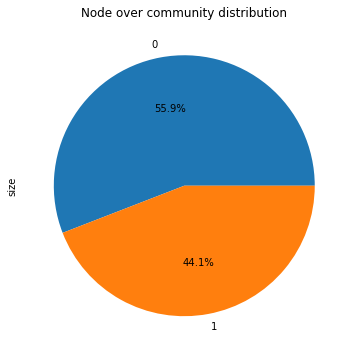

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,1.030303,34,0.106480,32,0.373371,34,0.100918,34,1.000000,23
1,0.727273,33,0.081949,9,0.317189,3,0.071692,33,1.000000,27
2,0.606061,3,0.023764,28,0.308651,33,0.057078,3,1.000000,16
3,0.363636,32,0.022231,31,0.227405,9,0.037157,32,1.000000,21
4,0.303030,9,0.016098,24,0.191036,32,0.031521,24,1.000000,19
5,0.303030,24,0.013799,3,0.174760,31,0.029765,9,1.000000,15
6,0.242424,30,0.007666,33,0.150123,24,0.026287,30,0.666667,30
7,0.242424,28,0.007666,29,0.134965,30,0.025639,28,0.500000,9
8,0.242424,31,0.007666,10,0.133479,28,0.024589,31,0.500000,31
9,0.181818,25,0.000000,30,0.131079,29,0.021075,25,0.400000,24


No timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.969697,1,0.264935,1,0.355483,1,0.097002,1,1.000000,22
1,0.545455,2,0.145116,14,0.265954,2,0.052878,2,1.000000,13
2,0.363636,4,0.096514,20,0.226470,14,0.035861,4,1.000000,17
3,0.303030,14,0.034497,2,0.211174,4,0.029536,14,1.000000,8
4,0.242424,6,0.016098,6,0.170955,8,0.029113,6,1.000000,18
5,0.242424,7,0.016098,7,0.147911,20,0.029113,7,0.666667,4
6,0.242424,8,0.008739,4,0.092397,22,0.024491,8,0.666667,5
7,0.181818,20,0.000000,5,0.092397,18,0.021979,5,0.666667,11
8,0.181818,5,0.000000,12,0.084252,13,0.021979,11,0.600000,14
9,0.181818,11,0.000000,22,0.079481,6,0.019604,20,0.500000,6


No timestamp data available
